### Importing the dataset

In [1]:
import pandas as pd

In [2]:
dataset = pd.read_csv('Final_AA.csv')
dataset = dataset.drop(['Headlines', 'Descriptions', 'Authors', 'Published_Dates', 'Publication', 'category', 'Keywords', 'Summaries', 'Source_URLs'], axis=1).dropna().reset_index(drop=True)
dataset.head()

,Articles
0,The contributors father was a member of Alcoho...
1,Image copyright Getty Images Alcoholics Anonym...
2,Image caption The true nature of alcoholism is...
3,Image copyright Other Image caption An AA meet...
4,Image copyright Thinkstock Everybody thinks th...


### Preliminary text exploration
Before we proceed with any text pre-processing, it is advisable to quickly explore the dataset in terms of word counts, most common and most uncommon words.

### Fetch word count for each abstract

In [3]:
#Fetch wordcount for each abstract
dataset['word_count'] = dataset['Articles'].apply(lambda x: len(str(x).split(" ")))
dataset[['Articles','word_count']].head()

,Articles,word_count
0,The contributors father was a member of Alcoho...,121
1,Image copyright Getty Images Alcoholics Anonym...,372
2,Image caption The true nature of alcoholism is...,952
3,Image copyright Other Image caption An AA meet...,1580
4,Image copyright Thinkstock Everybody thinks th...,1223


In [4]:
## Descriptive statistics of word counts
dataset.word_count.describe()

count      876.000000
mean       685.986301
std        906.872987
min          4.000000
25%        214.750000
50%        478.000000
75%        906.000000
max      14812.000000
Name: word_count, dtype: float64

The average word count is about 685 words per article. The word count ranges from a minimum of 4 to a maximum of 14812. The word count is important to give us an indication of the size of the dataset that we are handling as well as the variation in word counts across the rows.

### Most common and uncommon words
A peek into the most common words gives insights not only on the frequently used words but also words that could also be potential data specific stop words. A comparison of the most common words and the default English stop words will give us a list of words that need to be added to a custom stop word list.

In [5]:
#Identify common words
freq = pd.Series(' '.join(dataset['Articles']).split()).value_counts()[:10]
freq

the     27414
of      16226
to      15898
and     14967
a       12865
in      10367
is       5898
for      5617
that     4848
was      4793
dtype: int64

In [6]:
#Identify uncommon words
freq1 =  pd.Series(' '.join(dataset 
         ['Articles']).split()).value_counts()[-10:]
freq1

Saraswathi       1
sá»¥p.           1
rewriting        1
alcoholics,"     1
Efron            1
Hadley           1
Â“inequitable    1
Almighty;        1
1,000th          1
thrive           1
dtype: int64

### Text Pre-processing

In [7]:
# Libraries for text preprocessing
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import nltk
import re

**Removing stopwords**: Stop words include the large number of prepositions, pronouns, conjunctions etc in sentences. These words need to be removed before we analyse the text, so that the frequently used words are mainly the words relevant to the context and not common words used in the text.

There is a default list of stopwords in python nltk library. In addition, we might want to add context specific stopwords for which the “most common words” that we listed in the beginning will be helpful. We will now see how to create a list of stopwords and how to add custom stopwords:

In [8]:
##Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english"))
##Creating a list of custom stopwords
new_words = ["using", "show", "result", "large", "also", "iv", "one", "two", "new", "previously", "shown"]
stop_words = stop_words.union(new_words)

We will now carry out the pre-processing tasks step-by-step to get a cleaned and normalised text corpus:

In [9]:
corpus = []
for i in range(0, dataset.word_count.count()):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', dataset['Articles'][i])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    ##Stemming
    ps=PorterStemmer()
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

Let us now view an item from the corpus:

In [10]:
#View corpus item
corpus[400]

'image copyright image caption alamy workaholic anonymous alcoholic anonymous image caption getty image bryan robinson chained desk image caption getty image malissa clark bergen work addiction scale image caption getty image image caption getty image bridge recovery bbc capital'

### Data Exploration
We will now visualize the text corpus that we created after pre-processing to get insights on the most frequently used words.

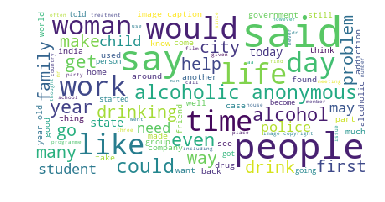

In [11]:
#Word cloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from os import path

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=1000)

## Creating a vector of word counts

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
import re
cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

In [13]:
list(cv.vocabulary_.keys())[:10]

['contributor',
 'father',
 'member',
 'alcoholic',
 'anonymous',
 'drinking',
 'alcohol',
 'last',
 'year',
 'life']

### Visualize top N uni-grams, bi-grams & tri-grams
We can use the CountVectoriser to visualise the top 20 unigrams, bi-grams and tri-grams.

**Bar plot of most frequently occurring uni-grams**

In [14]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["uni-grams", "Freq"]
print(top_df)

     uni-grams  Freq
0         said  2166
1       people  1854
2         year  1805
3      alcohol  1620
4          say  1458
5    alcoholic  1393
6         time  1268
7          day  1141
8        would  1131
9         life  1068
10        like  1003
11        drug   981
12    drinking   947
13   anonymous   923
14        help   907
15       image   891
16       woman   883
17  chandigarh   883
18       drink   843
19     problem   818


[Text(0, 0, 'said'),
 Text(0, 0, 'people'),
 Text(0, 0, 'year'),
 Text(0, 0, 'alcohol'),
 Text(0, 0, 'say'),
 Text(0, 0, 'alcoholic'),
 Text(0, 0, 'time'),
 Text(0, 0, 'day'),
 Text(0, 0, 'would'),
 Text(0, 0, 'life'),
 Text(0, 0, 'like'),
 Text(0, 0, 'drug'),
 Text(0, 0, 'drinking'),
 Text(0, 0, 'anonymous'),
 Text(0, 0, 'help'),
 Text(0, 0, 'image'),
 Text(0, 0, 'woman'),
 Text(0, 0, 'chandigarh'),
 Text(0, 0, 'drink'),
 Text(0, 0, 'problem')]

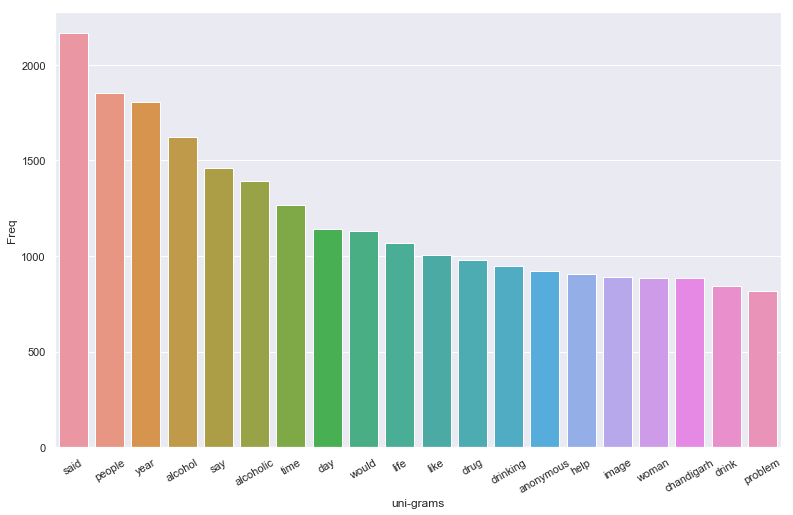

In [15]:
#Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="uni-grams", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

**Bar plot of most frequently occurring bi-grams**

In [16]:
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top2_words = get_top_n2_words(corpus, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)

                   Bi-gram  Freq
0      alcoholic anonymous   628
1            image caption   404
2                 year old   315
3          image copyright   285
4                   org uk   208
5               name event   200
6             event detail   200
7   additional information   197
8                 per cent   170
9            mental health   154
10             th november   153
11                year ago   140
12            tribune news   131
13            news service   127
14               last year   124
15            drug alcohol   120
16                 pm name   120
17            young people   113
18          event location   107
19             getty image   106


[Text(0, 0, 'alcoholic anonymous'),
 Text(0, 0, 'image caption'),
 Text(0, 0, 'year old'),
 Text(0, 0, 'image copyright'),
 Text(0, 0, 'org uk'),
 Text(0, 0, 'name event'),
 Text(0, 0, 'event detail'),
 Text(0, 0, 'additional information'),
 Text(0, 0, 'per cent'),
 Text(0, 0, 'mental health'),
 Text(0, 0, 'th november'),
 Text(0, 0, 'year ago'),
 Text(0, 0, 'tribune news'),
 Text(0, 0, 'news service'),
 Text(0, 0, 'last year'),
 Text(0, 0, 'drug alcohol'),
 Text(0, 0, 'pm name'),
 Text(0, 0, 'young people'),
 Text(0, 0, 'event location'),
 Text(0, 0, 'getty image')]

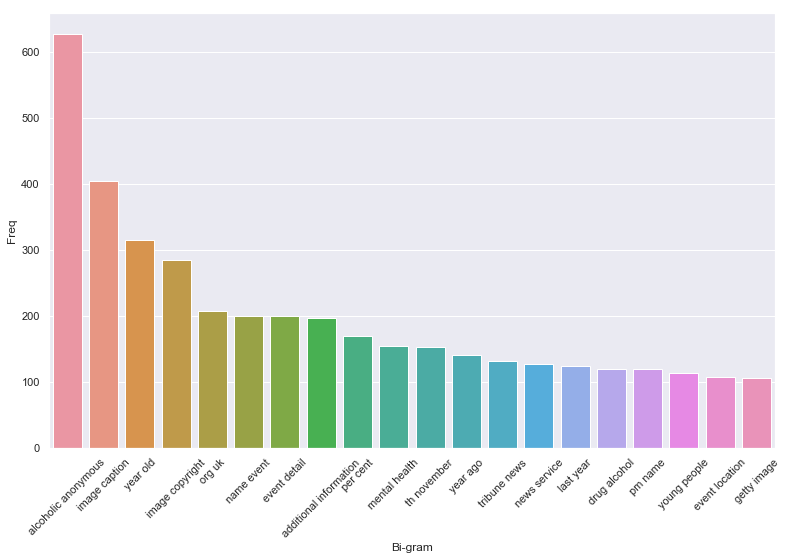

In [17]:
#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)

### Bar plot of most frequently occurring Tri-grams

In [18]:
#Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top3_words = get_top_n3_words(corpus, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
print(top3_df)

                       Tri-gram  Freq
0          tribune news service   127
1                 pm name event   120
2         image copyright getty    80
3         copyright getty image    80
4                th november pm    80
5              november pm name    73
6        alcoholic anonymous aa    68
7   alcoholic anonymous meeting    65
8       news service chandigarh    65
9               date time event    54
10          image image caption    51
11            getty image image    49
12          november name event    41
13             th november name    40
14     like alcoholic anonymous    39
15              event date time    39
16          disabled access yes    32
17  medium playback unsupported    31
18  playback unsupported device    31
19    unsupported device medium    31


[Text(0, 0, 'tribune news service'),
 Text(0, 0, 'pm name event'),
 Text(0, 0, 'image copyright getty'),
 Text(0, 0, 'copyright getty image'),
 Text(0, 0, 'th november pm'),
 Text(0, 0, 'november pm name'),
 Text(0, 0, 'alcoholic anonymous aa'),
 Text(0, 0, 'alcoholic anonymous meeting'),
 Text(0, 0, 'news service chandigarh'),
 Text(0, 0, 'date time event'),
 Text(0, 0, 'image image caption'),
 Text(0, 0, 'getty image image'),
 Text(0, 0, 'november name event'),
 Text(0, 0, 'th november name'),
 Text(0, 0, 'like alcoholic anonymous'),
 Text(0, 0, 'event date time'),
 Text(0, 0, 'disabled access yes'),
 Text(0, 0, 'medium playback unsupported'),
 Text(0, 0, 'playback unsupported device'),
 Text(0, 0, 'unsupported device medium')]

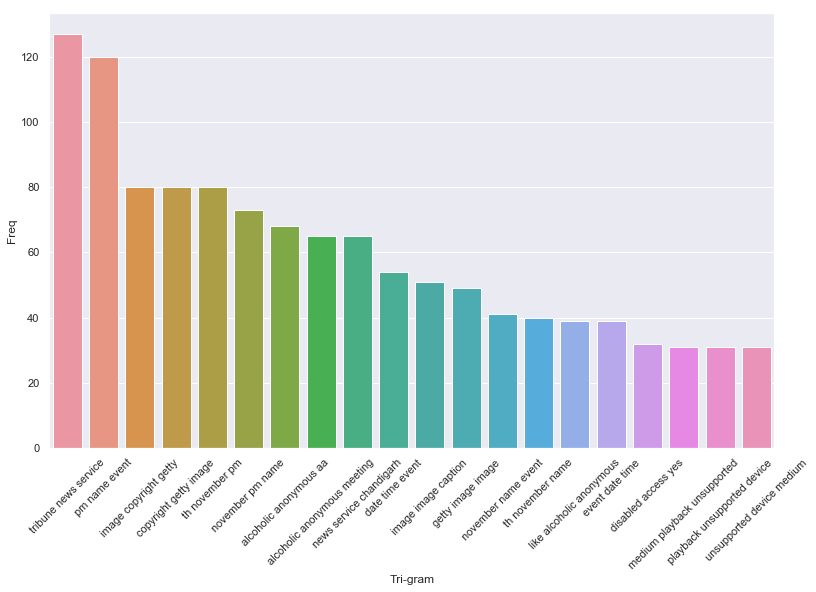

In [19]:
#Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45)

### Converting to a matrix of integers

The next step of refining the word counts is using the TF-IDF vectoriser. The deficiency of a mere word count obtained from the countVectoriser is that, large counts of certain common words may dilute the impact of more context specific words in the corpus. This is overcome by the TF-IDF vectoriser which penalizes words that appear several times across the document. TF-IDF are word frequency scores that highlight words that are more important to the context rather than those that appear frequently across documents.

**TF-IDF consists of 2 components:**

- TF — term frequency

- IDF — Inverse document frequency

In [20]:
from sklearn.feature_extraction.text import TfidfTransformer
 
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)
# get feature names
feature_names=cv.get_feature_names()
 
# fetch document for which keywords needs to be extracted
doc=corpus[500]
 
#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

Based on the TF-IDF scores, we can extract the words with the highest scores to get the keywords for a document.

In [21]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())
#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,5)
 
# now print the results
print("\nAbstract:")
print(doc)
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])


Abstract:
person drink five beer account third daily energy intake representational image drunchies desire eat salty unhealthy food night heavy drinking may contributing obesity epidemic among college student scientist say researcher university buffalo u decided look sample college student better understand drinking affect eat night first meal next day likely hungover given obesity epidemic rate alcohol consumption college campus need aware negative effect alcohol consumption impact people eating drinking said jessica kruger assistant professor university buffalo research effect drinking diet scarce kruger said adding eating unhealthy food following alcohol consumption often overlooked behaviour traditional addiction research inspiration study published californian journal health promotion came ad researcher saw university newspaper said got drunchies ad pizza taco fast food place open late bar closed kruger said average beer contains calorie person drink five beer account third daily